# Image Segmentation
  
#### Task
* GIANA dataset으로 위내시경 이미지에서 용종을 segmentation 해보자
* Image size: 256으로 변경하여 수행 (baseline code는 `image_size`: 64)
* 밑에 제시된 여러가지 시도를 해보자
* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras.layers` and `tf.enable_eager_execution()`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)  

#### Dataset
* I use below dataset instead of [carvana-image-masking-challenge dataset](https://www.kaggle.com/c/carvana-image-masking-challenge/rules) in TensorFlow Tutorials which is a kaggle competition dataset.
  * carvana-image-masking-challenge dataset: Too large dataset (14GB)
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500

#### Base code
* Dataset: train, test로 split
* Input data shape: (`batch_size`, 64, 64, 3)
* Output data shape: (`batch_size`, 64, 64, 1)
* Architecture: 
  * 간단한 U-Net 구조
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `tf.data.Dataset` 사용
  * `tf.GradientTape()` 사용 for weight update
* Evaluation
  * MeanIOU: Image Segmentation에서 많이 쓰이는 evaluation measure
  * tf.version 1.12 API: [`tf.metrics.mean_iou`](https://www.tensorflow.org/api_docs/python/tf/metrics/mean_iou)
    * `tf.enable_eager_execution()`이 작동하지 않음
    * 따라서 예전 방식대로 `tf.Session()`을 이용하여 작성하거나 아래와 같이 2.0 version으로 작성하여야 함
  * tf.version 2.0 API: [`tf.keras.metrics.MeanIoU`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics/MeanIoU)

#### Try some techniques
* Change model architectures (Custom model)
  * Try another models (DeepLAB, Hourglass, Encoder-Decoder 모델)
* Data augmentation
* Various regularization methods

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Get all the files 
Since this tutorial will be using a dataset from [Giana Dataset](https://giana.grand-challenge.org/Dates/).

In [2]:
# Unfortunately you cannot downlaod GIANA dataset from website
# So I upload zip file on my dropbox
# if you want to download from my dropbox uncomment below
# !wget https://goo.gl/mxikqa
# !mv mxikqa sd_train.zip
# !unzip sd_train.zip
# !mkdir ../../datasets
# !mv sd_train ../../datasets
# !rm sd_train.zip

In [3]:
dataset_dir = '../../datasets/sd_train'
img_dir = os.path.join(dataset_dir, "train")
label_dir = os.path.join(dataset_dir, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=219)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


## Visualize
Let's take a look at some of the examples of different images in our dataset.

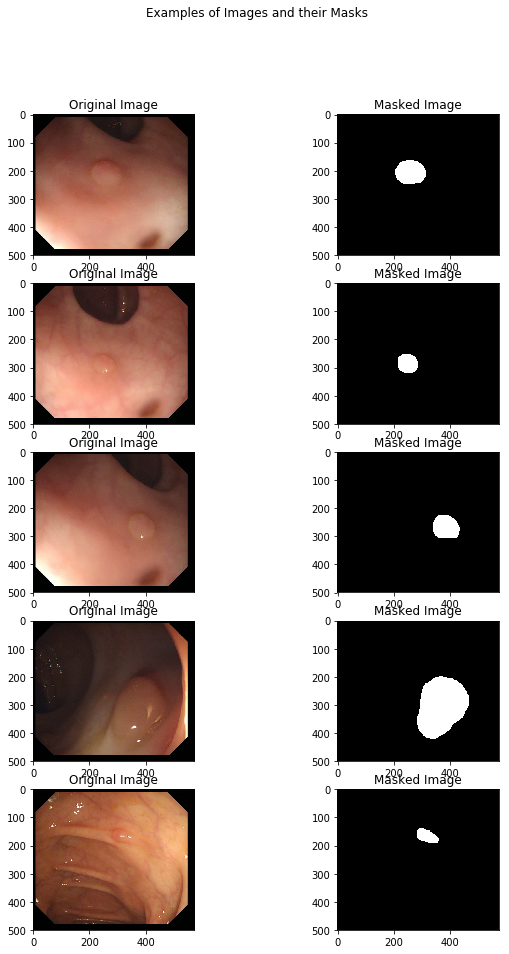

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(Image.open(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Set up
Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters: 

In [8]:
# Set hyperparameters
image_size = 64
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 2
print_steps = 10
save_epochs = 2
train_dir = 'train/exp1'

## Build our input pipeline with `tf.data`
Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. If you are unfamiliar with **tf.data** you should check out my other tutorial introducing the concept! 

### Our input pipeline will consist of the following steps:
1. Read the bytes of the file in from the filename - for both the image and the label. Recall that our labels are actually images with each pixel annotated as car or background (1, 0). 
2. Decode the bytes into an image format
3. Apply image transformations: (optional, according to input parameters)
  * `resize` - Resize our images to a standard size (as determined by eda or computation/memory restrictions)
    * The reason why this is optional is that U-Net is a fully convolutional network (e.g. with no fully connected units) and is thus not dependent on the input size. However, if you choose to not resize the images, you must use a batch size of 1, since you cannot batch variable image size together
    * Alternatively, you could also bucket your images together and resize them per mini-batch to avoid resizing images as much, as resizing may affect your performance through interpolation, etc.
  * `hue_delta` - Adjusts the hue of an RGB image by a random factor. This is only applied to the actual image (not our label image). The `hue_delta` must be in the interval `[0, 0.5]` 
  * `horizontal_flip` - flip the image horizontally along the central axis with a 0.5 probability. This transformation must be applied to both the label and the actual image. 
  * `width_shift_range` and `height_shift_range` are ranges (as a fraction of total width or height) within which to randomly translate the image either horizontally or vertically. This transformation must be applied to both the label and the actual image. 
  * `rescale` - rescale the image by a certain factor, e.g. 1/ 255.
4. Shuffle the data, repeat the data (so we can iterate over it multiple times across epochs), batch the data, then prefetch a batch (for efficiency).

It is important to note that these transformations that occur in your data pipeline must be symbolic transformations. 

#### Why do we do these image transformations?
This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

## Processing each pathname

In [ ]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair
  img_str = tf.read_file(fname)
  img = tf.image.decode_bmp(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_bmp(label_img_str, channels=1)
  
  resize = [image_size, image_size]
  img = tf.image.resize_images(img, resize)
  label_img = tf.image.resize_images(label_img, resize)
  
  scale = 1 / 255.
  img = tf.to_float(img) * scale
  label_img = tf.to_float(label_img) * scale
  
  return img, label_img

In [ ]:
def get_baseline_dataset(filenames,
                         labels,
                         threads=5,
                         batch_size=batch_size,
                         shuffle=True):
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x * 10)
  
  dataset = dataset.batch(batch_size)
  return dataset

## Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [ ]:
train_dataset = get_baseline_dataset(x_train_filenames,
                                     y_train_filenames)
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    shuffle=False)

In [ ]:
train_dataset

### Plot some train data

In [ ]:
for images, labels in train_dataset.take(1):
  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = images[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(labels[0, :, :, 0])
  plt.show()

## Build the model
We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 

### The Keras Functional API
The Keras functional API is used when you have multi-input/output models, shared layers, etc. It's a powerful API that allows you to manipulate tensors and build complex graphs with intertwined datastreams easily. In addition it makes layers and models both callable on tensors.

* To see more examples check out the [get started guide](https://keras.io/getting-started/functional-api-guide/).

We'll build these helper functions that will allow us to ensemble our model block operations easily and simply.

In [ ]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16

center = conv_block(encoder3_pool, 512) # center

decoder3 = decoder_block(center, encoder3, 256) # 32
decoder2 = decoder_block(decoder3, encoder2, 128) # 64
decoder1 = decoder_block(decoder2, encoder1, 64) # 128
decoder0 = decoder_block(decoder1, encoder0, 32) # 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

### Create a model (UNet)
Using functional API, you must define your model by specifying the inputs and outputs associated with the model.

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model.summary()

## Defining custom metrics and loss functions

Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [ ]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [ ]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [ ]:
def bce_dice_loss(y_true, y_pred):
  loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
  return loss

## Setup a optimizer

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=2e-4)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = train_dir
if not tf.gfile.Exists(checkpoint_dir):
  tf.gfile.MakeDirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

## Train your model
Training your model with tf.data involves simply providing the model's fit function with your training/validation dataset, the number of steps, and epochs.

We also include a Model callback, ModelCheckpoint that will save the model to disk after each epoch. We configure it such that it only saves our highest performing model. Note that saving the model capture more than just the weights of the model: by default, it saves the model architecture, weights, as well as information about the training process such as the state of the optimizer, etc.

In [ ]:
%%time
tf.logging.info('Start Training.')

# save loss values for plot
loss_history = []
global_step = tf.train.get_or_create_global_step()
for epoch in range(max_epochs):
  
  for images, labels in train_dataset:
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = bce_dice_loss(labels, predictions)

    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables),
                              global_step=global_step)
    
    epochs = global_step.numpy() * batch_size / float(num_train_examples)
    duration = time.time() - start_time

    if global_step.numpy() % print_steps == 0:
      clear_output(wait=True)
      examples_per_sec = batch_size  / float(duration)
      print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss, examples_per_sec, duration))

      loss_history.append([epochs, loss])

      # print sample image
      for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images)
        
      plt.figure(figsize=(10, 20))
      plt.subplot(1, 3, 1)
      plt.imshow(test_images[0,: , :, :])
      plt.title("Input image")
  
      plt.subplot(1, 3, 2)
      plt.imshow(test_labels[0, :, :, 0])
      plt.title("Actual Mask")
      
      plt.subplot(1, 3, 3)
      plt.imshow(predictions[0, :, :, 0])
      plt.title("Predicted Mask")
      plt.show()

  # saving (checkpoint) the model periodically
  if (epoch+1) % save_epochs == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

tf.logging.info('complete training...')

### Plot the loss

In [ ]:
loss_history = np.asarray(loss_history)
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()